In [1]:
import numpy as np
import pandas as pd
from ipywidgets import *

import matplotlib
import matplotlib.pyplot as plt
import json

from IPython.display import display

%matplotlib inline
matplotlib.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 300})

In [2]:
np.random.normal(size = 100)

array([-0.05871574, -1.29435985,  0.41066802, -2.37169441,  0.67981871,
       -0.59086565, -0.70234715, -0.93308024, -0.2039819 ,  2.54144763,
       -2.29954309,  0.08332156,  0.29098691, -0.62746474, -1.13425085,
        0.4408742 , -2.18099176, -0.33812048,  0.48855656, -0.12146366,
        0.19005031,  1.95838257,  0.29548144,  1.34210006, -0.52709296,
        1.16795791, -1.39447167, -0.18479017,  0.47333717,  1.08354992,
        2.53905528, -0.23953136, -0.01777834,  0.2164835 , -0.41039211,
       -0.97596377,  1.67248018, -0.4733931 ,  1.36163503,  0.82663716,
        0.73112548,  0.39078968, -0.85641742,  2.05639683,  1.06926371,
        1.7044271 ,  0.65850276, -1.81325765, -0.28739272,  0.05722656,
        1.66821971,  0.28493824,  0.19530597, -0.23820163, -0.04652645,
        0.8961411 , -2.02360271,  0.06881348,  1.13639035,  0.75211668,
       -0.33557717,  0.9120665 ,  0.69755806,  2.1783771 , -1.61564707,
       -0.1591656 ,  0.27215495, -0.04796734,  0.3772515 ,  1.40

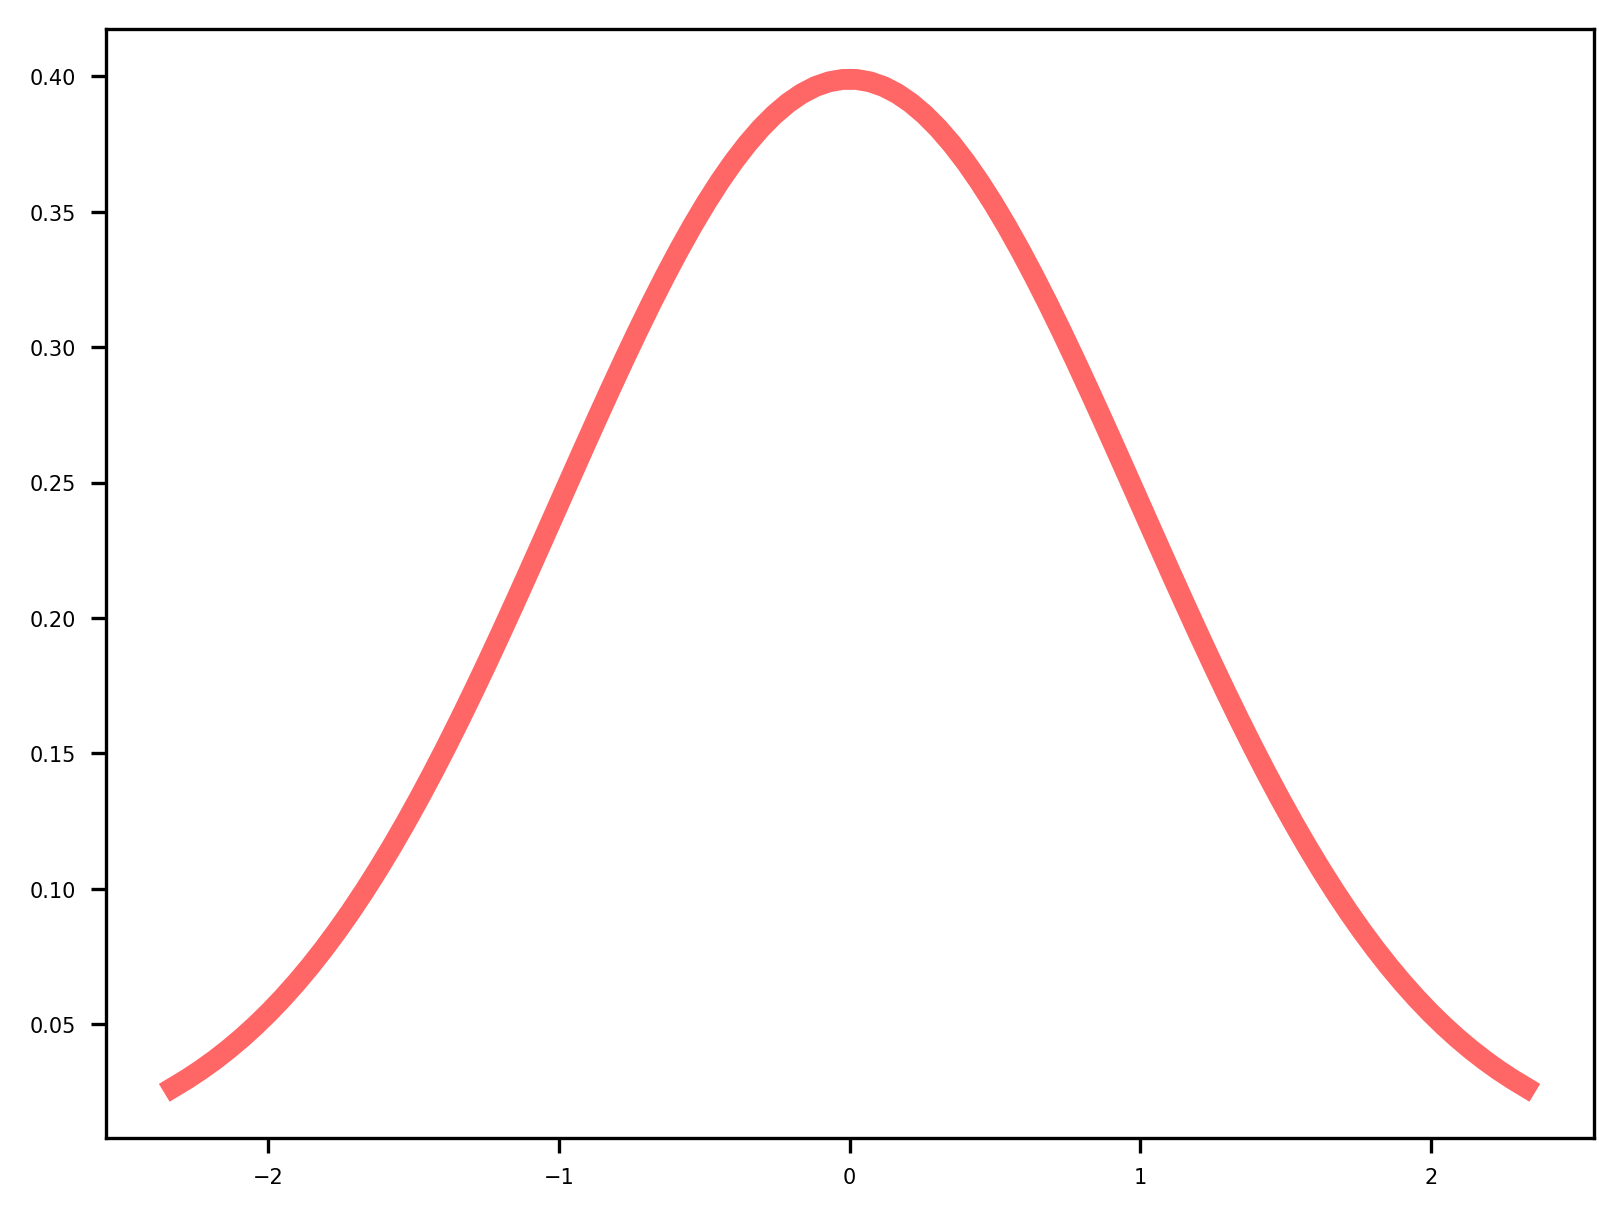

In [3]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

Output()

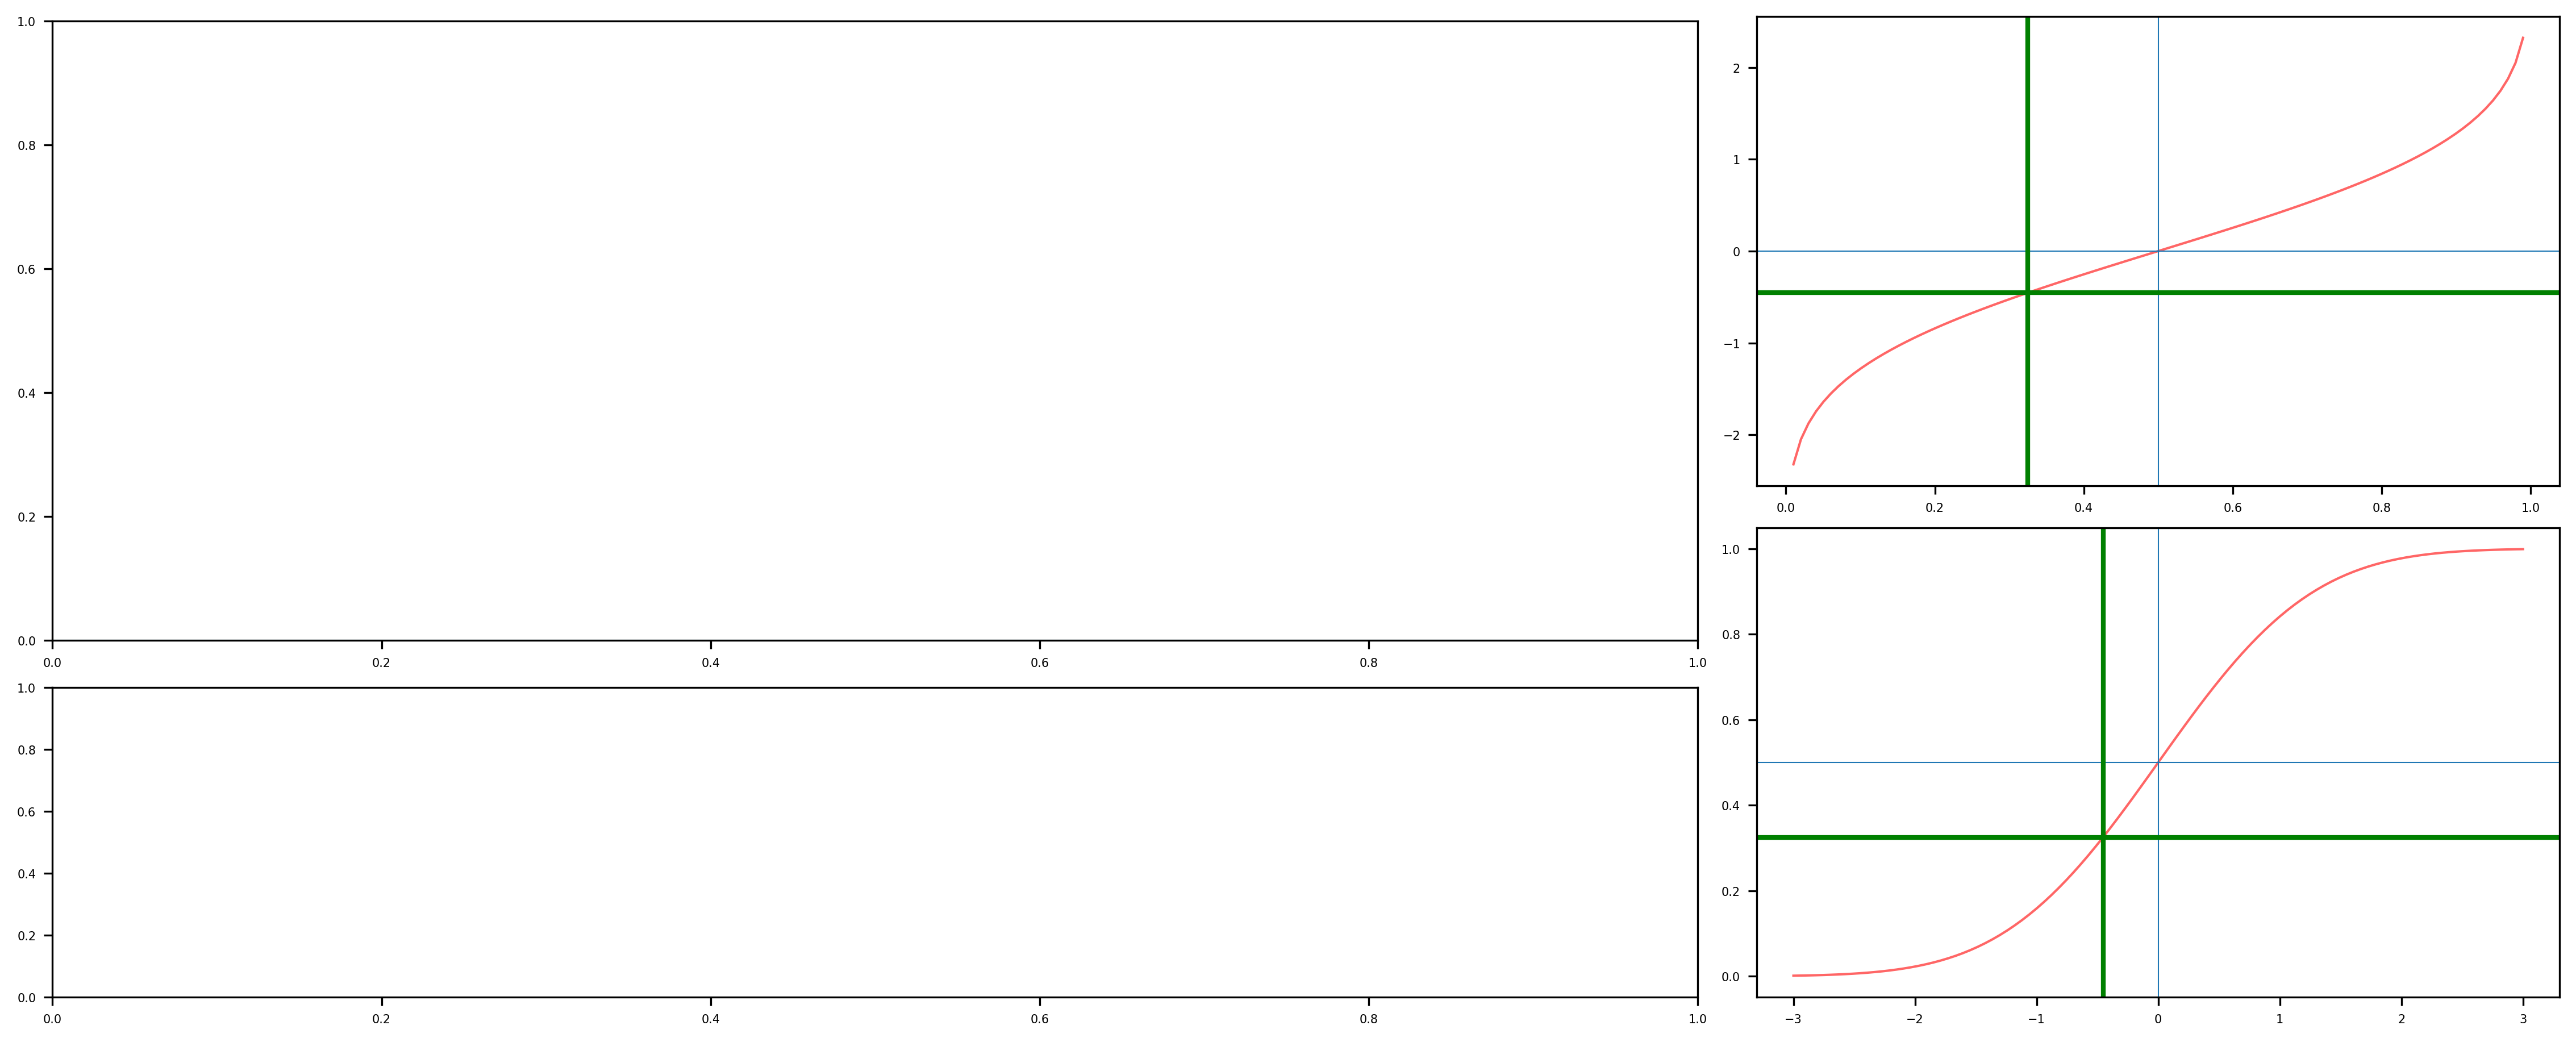

In [4]:
strategy = 'strategy-params/trading-curve'

strategy_params = {
    'risk': {'type': 'float', 'min': 0, 'max': 1, 'value': 0.02, 'step': 0.01},
    'winrate': {'type': 'float', 'value': 0.50, 'step': 0.001},
    'r2r': {'type': 'float', 'value': 2, 'step': 0.1},
    'n': {'type': 'int', 'value': 1000, 'step': 100, 'min':1},
    'cn': {'type': 'int', 'value': 10, 'step': 2},
    'fee': {'type': 'float', 'min': 0, 'max': 1, 'value': 0.002, 'step': 0.001},
    'slippage': {'type': 'float', 'min': 0, 'max': 1, 'value': 0.001, 'step': 0.001},
    'seed': {'type': 'int', 'min': 0, 'max': 100, 'value': 1, 'step': 1},
}
for pk, pv in strategy_params.items():
    pv['wdg'] = globals()[(pv['wdg'] if 'wdg' in pv else pv['type'].capitalize() + 'Text')](
        description=pk,disabled=False,continuous_update=False,
        value=pv['value'], step=pv['step']
    )
strategy_params = {**strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+5]) for i in range(0, len(wdgts), 5)])

df = None
cn = None
def printer(seed, risk, winrate, r2r, n, cn, fee, slippage):
    
    with open(f'{strategy}.json', "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    
    global df
    plt.close("all")
    fig = plt.figure(constrained_layout=True,figsize=(15,6))
    gs0 = fig.add_gridspec(1, 2, width_ratios=[2,1])

    gs00 = gs0[0,0].subgridspec(2, 1, height_ratios=[2,1])
    gs01 = gs0[0,1].subgridspec(2, 1, height_ratios=[1,1])

    ax001 = fig.add_subplot(gs00[0,0])
    ax002 = fig.add_subplot(gs00[1,0], sharex=ax001)
    ax003 = fig.add_subplot(gs01[0,0])
    ax004 = fig.add_subplot(gs01[1,0])
    
    xcut = norm.ppf(winrate)
    xperc = np.linspace(0,1, 100)
    ax003.plot(xperc, norm.ppf(xperc),
        'r-', lw=1, alpha=0.6, label='norm ppf')
    ax003.axvline(0.5)
    ax003.axhline()
    ax003.axhline(xcut, c='g', lw=2)
    ax003.axvline(winrate, c='g', lw=2)
    
    xnovar = np.linspace(-3, 3, 100)
    ax004.plot(xnovar, norm.cdf(xnovar),
        'r-', lw=1, alpha=0.6, label='norm cdf')
    ax004.axhline(0.5)
    ax004.axvline()
    ax004.axvline(xcut, c='g', lw=2)
    ax004.axhline(winrate, c='g', lw=2)
    
    ax001.axhline(0)
    df = pd.DataFrame()
    np.random.seed(seed)
    # df_lrets = pd.DataFrame({
    #     f'cret_{i}': np.log1p(awin * risk)
    #     for i in range(cn)
    #     for awin in [-1 + (1 + 1/r2r)*(np.random.randn(n) <= xcut)]
    # })
    df_lrets = pd.DataFrame(np.log1p( risk * (-1 + (1 + r2r)*(np.random.randn(n,cn) <= xcut))))
    df_cum_rets = df_lrets.cumsum(axis=0)
        
    # df['rv'] = np.random.normal(size = n)
    # df['ret'] = np.where(df.rv > xcut, - risk, r2r * risk)
    # df.plot(ax=ax001)
    # ret_cols = [f'ret_{i}' for i in range(cn)]
    # cret_cols = [f'cret_{i}' for i in range(cn)]

    # df['tot_ret'] = df[ret_cols].mean(axis=1)
    # df['tot_cret'] = (df.tot_ret + 1).cumprod()

    df_cum_rets.plot(ax=ax001, legend=False)
    df_cum_rets.mean(axis=1).plot(ax=ax002, legend=False)
    
    ax002.axhline()
    # df.tot_cret.plot(ax=ax002, lw=1, c='b')
    # df['cap'] = df.ret.add(1).cumprod()
    # ax001.plot(df.cap)
    
    # df.avg().plot(ax=ax002)
    
with open(f'{strategy}.json') as f: 
    js = json.loads(f.read());
    for k, v in strategy_params.items(): 
        if k in js: v['wdg'].value=js[k];
        
out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()})
display(ui, out)  

In [59]:
cn = 20
n=100
winrate = 0.4
r2r = 1/2
xcut = norm.ppf(winrate)
risk = 0.01
df_lrets = pd.DataFrame({
    f'cret_{i}': np.log1p(awin * risk)
    for i in range(cn)
    for awin in [-1 + (1 + 1/r2r)*(np.random.randn(n) <= xcut)]
})
df_lrets.cumsum(axis=0)

,cret_0,cret_1,cret_2,cret_3,cret_4,cret_5,cret_6,cret_7,cret_8,cret_9,cret_10,cret_11,cret_12,cret_13,cret_14,cret_15,cret_16,cret_17,cret_18,cret_19
0,0.019803,0.019803,-0.010050,0.019803,0.019803,0.019803,0.019803,-0.010050,-0.010050,-0.010050,0.019803,-0.010050,-0.010050,0.019803,0.019803,-0.010050,-0.010050,-0.010050,0.019803,0.019803
1,0.039605,0.009752,-0.020101,0.039605,0.039605,0.039605,0.039605,0.009752,-0.020101,-0.020101,0.039605,0.009752,-0.020101,0.009752,0.009752,0.009752,-0.020101,-0.020101,0.039605,0.039605
2,0.029555,0.029555,-0.030151,0.029555,0.029555,0.059408,0.059408,-0.000298,-0.030151,-0.030151,0.059408,0.029555,-0.030151,0.029555,-0.000298,0.029555,-0.030151,-0.030151,0.029555,0.029555
3,0.049358,0.019505,-0.010348,0.019505,0.019505,0.049358,0.079211,-0.010348,-0.040201,-0.040201,0.079211,0.049358,-0.040201,0.019505,-0.010348,0.049358,-0.040201,-0.040201,0.019505,0.049358
4,0.039307,0.039307,-0.020399,0.039307,0.009454,0.069160,0.069160,0.009454,-0.020399,-0.050252,0.069160,0.039307,-0.050252,0.039307,-0.020399,0.069160,-0.050252,-0.020399,0.009454,0.039307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.139727,0.229286,-0.099096,0.288992,0.139727,-0.158802,0.199433,0.408404,0.139727,0.438257,0.468110,0.050169,0.259139,0.080021,0.169580,0.348698,0.378551,0.259139,0.408404,0.169580
96,0.159530,0.219236,-0.079294,0.278942,0.159530,-0.139000,0.189383,0.398354,0.129677,0.428207,0.487913,0.040118,0.249089,0.069971,0.159530,0.368501,0.368501,0.249089,0.428207,0.189383
97,0.179333,0.209186,-0.059491,0.268892,0.149480,-0.119197,0.209186,0.418156,0.149480,0.418156,0.477862,0.059921,0.239039,0.089774,0.149480,0.358450,0.388303,0.239039,0.448009,0.179333
98,0.169282,0.228988,-0.039688,0.288694,0.169282,-0.099394,0.228988,0.408106,0.139429,0.408106,0.467812,0.079723,0.228988,0.079723,0.139429,0.378253,0.378253,0.228988,0.467812,0.169282


In [57]:
# lret_cols = [f'ret_{i}' for i in range(cn)]
# cret_cols = [f'cum_lret_{i}' for i in range(cn)]
pd.DataFrame(np.log1p( risk * (-1 + (1 + 1/r2r)*(np.random.randn(n,cn) <= xcut))))

TypeError: 'NoneType' object cannot be interpreted as an integer